In [103]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

### Assumptions

In [104]:
g = 9.81

rho_w = 1000 # density of water [kg/m^3]

rho_cc = 2850 # density of continental crust [kg/m^3]
rho_cm = 3338 # density of continental lithospheric mantle [kg/m^3]
cm = 200000 # thickness of continental  mantle

rho_oc = 2900 # density of oceanic crust
rho_om = 3300 # density of depleted oceanic lithospheric mantle
oc = 7000 # thickness of oceanic crust layer 
om = 50000 # thickness of depleted oceanic lithospheric mantle

rho_m = 3300 # density of asthenospheric mantle

### Isostatic balance equation
Isostatic balance equation (assume sea level = 0):

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_w w_A + \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

- $\rho_i$ is the density of water, oceanic crust, (depleted) oceanic mantle, (asthenospheric) mantle, continental crust, etc.
- $d_i$ is the thickness of the oceanic crust, continental crust, etc.
- $w_B$ is the thickness of the water layer above the oceanic lithosphere
- $w_A$ is the thickness of the water layer above the continental lithosphere.


where the compensation depth is taken as the base of the continental lithospheric mantle, which determines the depth of the asthenospheric mantle ($d_m$).

Assuming $w_A = 0$:

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

Since we have two unknowns ($d_m$ and $w_B$), we use the equation:

$$d_{cc}+d_{cm} = w_B + d_{oc} + d_{om} + d_m$$

solving for $w_B$:
$$w_B = d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}$$

substituting into the isostatic balance equation:

$$\rho_w(d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}) + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

solving for $d_m$:
$$d_m = \frac{d_{cc}(\rho_{cc} - \rho_w) + d_{cm}(\rho_{cm} - \rho_w) + d_{om}(\rho_w - \rho_{om}) + d_{oc}(\rho_w - \rho_{oc})}{\rho_m -\rho_w}$$

In [105]:
# varying the thickness of the continental crust
cc = np.array(range(30000,60000,5000))

# solving for the thickness of the asthenospheric mantle
m = (cc*(rho_cc-rho_w)+cm*(rho_cm-rho_w)+om*(rho_w-rho_om)+oc*(rho_w-rho_oc))\
/(rho_m-rho_w)

now solving for $w_B$:

In [106]:
w_B = cc + cm - om - m - oc
print("Crustal thickness, mantle thickness, water depth:")
for i, water in enumerate(w_B):
    print("[%.0f km, %.1f km, %.1f km]"%((cc[i]/1000),(m[i]/1000),(w_B[i]/1000)))

Crustal thickness, mantle thickness, water depth:
[30 km, 171.7 km, 1.3 km]
[35 km, 175.7 km, 2.3 km]
[40 km, 179.7 km, 3.3 km]
[45 km, 183.7 km, 4.3 km]
[50 km, 187.7 km, 5.3 km]
[55 km, 191.8 km, 6.2 km]


checking that this is indeed equal to the continental lithospheric layer:

In [107]:
print("Crustal thickness, oceanic lithosphere, continental lithosphere:")
for i in range(len(w_B)):
    print("[%.0f km, %i km, %i km]"%((cc[i]/1000),((w_B[i]+oc+om+m[i])/1000), ((cm+cc[i])/1000)))

Crustal thickness, oceanic lithosphere, continental lithosphere:
[30 km, 230 km, 230 km]
[35 km, 235 km, 235 km]
[40 km, 240 km, 240 km]
[45 km, 245 km, 245 km]
[50 km, 250 km, 250 km]
[55 km, 255 km, 255 km]


### Calculating the lithostatic pressure
$$P = \int_{a}^{b} \rho(z) g dz$$

#### Continental lithosphere

In [108]:
compensation_depth = cc + cm # compensation depth

initial_depth = 0
depth_increment = 1000
final_depth = compensation_depth+depth_increment
z = [[]]*len(cc)
for i, depth in enumerate(final_depth):
    z[i] = list(range(initial_depth,depth,depth_increment)) # depth [m]

In [109]:
def calc_pressure_continent(z, w, cc):
    """
    Calculates the lithostatic pressure of the  continental lithosphere
    given the depth (z), water layer above (w), and thickness
    of the continental crust (cc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            # integrate the density over the water layer
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w + cc:
            # integrate the density over the crustal layer,
            # plus the total pressure from the water layer
            y, err = integrate.quad(lambda z: rho_cc*g,w,val)
            y+= rho_w*g*w
        elif w + cc <= abs(val) <= w + cc + cm:
            # integrate the density over the continental lithospheric mantle layer,
            # plus the total pressure from the water + crustal layer
            y, err = integrate.quad(lambda z: rho_cm*g,w+cc,val)
            y+= rho_w*g*w + rho_cc*g*cc
        else:
            # integrate the density over the mantle layer,
            # plus the total pressure from the water + crustal + cm layer
            y, err = integrate.quad(lambda z: rho_m*g,w+cc+cm,val)
            y+= rho_w*g*w + rho_cc*g*cc + rho_cm*g*cm
        P[i] = y/1e6
    return P

#### Oceanic lithosphere

In [110]:
def calc_pressure_ocean(z, w, oc):
    """
    Calculates the lithostatic pressure of the  oceanic lithosphere
    given the depth (z), water layer above (w), and thickness
    of the oceanic crust (oc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w+oc:
            y, err = integrate.quad(lambda z: rho_oc*g,w,val)
            y+= rho_w*g*w
        elif w+oc < abs(val) <= w+oc+om:
            y, err = integrate.quad(lambda z: rho_om*g,w+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc
        else:
            y, err = integrate.quad(lambda z: rho_m*g,w+om+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc + rho_om*g*om
        P[i] = y/1e6
    return P

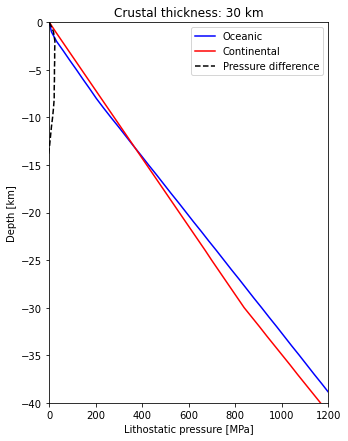

Maximum pressure difference: 24 MPa


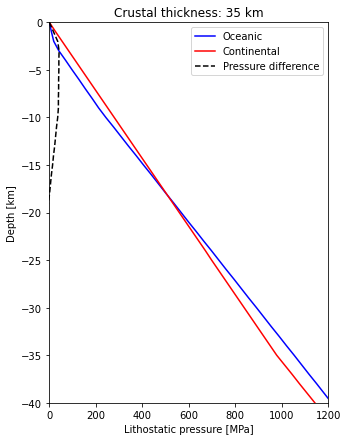

Maximum pressure difference: 42 MPa


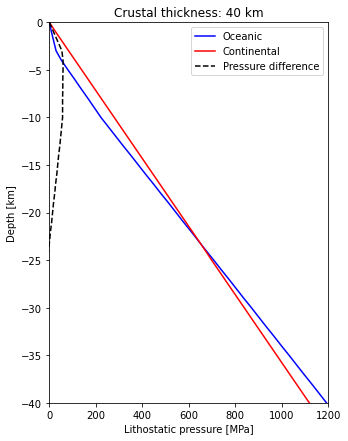

Maximum pressure difference: 59 MPa


Maximum pressure difference: 77 MPa


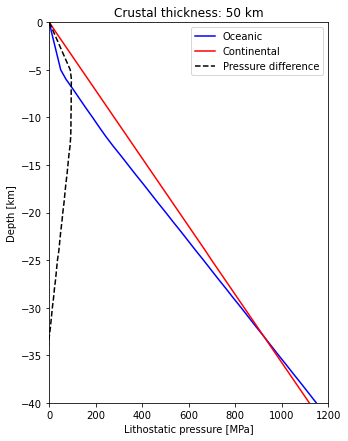

Maximum pressure difference: 95 MPa


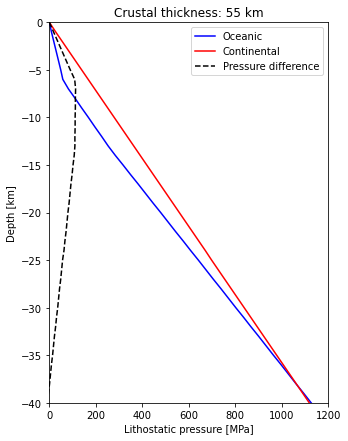

Maximum pressure difference: 113 MPa


In [115]:
# assuming that continents are at sea level
w_A = 0
P_A = [[]]*len(cc)
P_B = [[]]*len(cc)
P_diff = [[]]*len(cc)

for i, c in enumerate(cc):
    P_A[i] = calc_pressure_continent(z[i], w_A, c)
    P_B[i] = calc_pressure_ocean(z[i], w_B[i], oc)
    plt.figure(figsize=(5,7))
    plt.plot(P_B[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A[i],[-j/1000 for j in z[i]],'r-')
    P_diff[i] = P_A[i]-P_B[i] 
    plt.plot(P_diff[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff[i]))

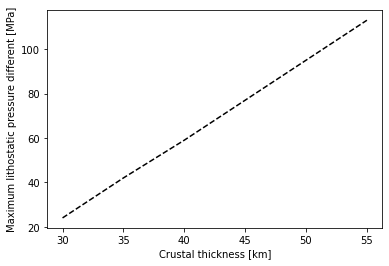

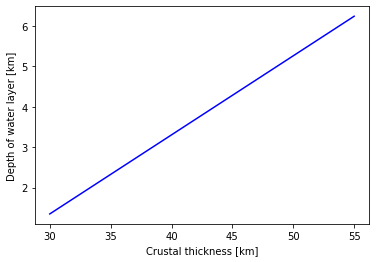

In [112]:
P_diff_max = []*len(cc)
for i in P_diff:
    P_diff_max.append(max(i))
    # print(P_diff_max)
plt.plot(cc/1000,np.array(P_diff_max),'k--')
plt.ylabel('Maximum lithostatic pressure different [MPa]')
plt.xlabel('Crustal thickness [km]')
plt.show()

plt.plot(cc/1000,w_B/1000,'b')
plt.ylabel('Depth of water layer [km]')
plt.xlabel('Crustal thickness [km]')
plt.show()